# 0. 

기본 모듈

In [1]:
!pip install holiday
!pip install prophet
!pip install pystan~=2.14
!pip install fbprophet 
!pip install statsmodels==0.11.1|

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cmdstanpy-1.0.7-py3-none-any.whl (80 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.7 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Attempting uninstall: cmdstanpy
    Found existing insta

In [2]:
#나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

# New Section

In [3]:
# Prophet Library
from fbprophet import Prophet

# Prophet 시각화 도구
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot

import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import RobustScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import warnings
import datetime
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 데이터 불러오기

In [5]:
#matplotlib font 설정
import matplotlib .pyplot as plt
plt.rc('font', family='NanumGothic')

In [6]:
grape = pd.read_csv('/content/drive/MyDrive/기업연계프로젝트_9조/data/extracted/캠벨얼리_전처리후.csv') 
mushroom = pd.read_csv('/content/drive/MyDrive/기업연계프로젝트_9조/data/extracted/팽이버섯_전처리후.csv') 
tomato = pd.read_csv('/content/drive/MyDrive/기업연계프로젝트_9조/data/extracted/10월20일토마토바꾸라고한거.csv', index_col = 0)
welsh = pd.read_csv('/content/drive/MyDrive/기업연계프로젝트_9조/data/extracted/10월20일대파바꾸라고한거.csv', index_col = 0)
plant = pd.read_csv('/content/drive/MyDrive/기업연계프로젝트_9조/data/extracted/10월20일깻잎바꾸라고한거.csv', index_col = 0)

In [7]:
grape.shape, mushroom.shape, tomato.shape, welsh.shape, plant.shape

((1770, 9), (1770, 9), (1770, 12), (1770, 12), (1770, 12))

In [8]:
tomato.drop(columns=['계절_가을', '계절_겨울', '계절_봄', '계절_여름'], inplace=True)
welsh.drop(columns=['계절_가을', '계절_겨울', '계절_봄', '계절_여름'], inplace=True)
plant.drop(columns=['계절_가을', '계절_겨울', '계절_봄', '계절_여름'], inplace=True)

In [9]:
private = pd.read_csv('/content/drive/MyDrive/기업연계프로젝트_9조/data/raw/private_data.csv')
submission = pd.read_csv('/content/drive/MyDrive/기업연계프로젝트_9조/data/raw/sample_submission.csv')

print(private.shape)
print(submission.shape)

(291, 44)
(228, 22)


In [10]:
tomato = tomato.round(2)
welsh = welsh.round(2)
plant = plant.round(2)

In [11]:
tomato.columns

Index(['date', '요일', '토마토_거래량(kg)', '토마토_가격(원/kg)', '토마토_거래량의_1주전_평균',
       '토마토_가격의_1주전_평균', '토마토_거래량의_2주전_평균', '토마토_가격의_2주전_평균'],
      dtype='object')

In [12]:
df = pd.merge(grape, mushroom, on=['date', '요일', '계절'])
df = pd.merge(df, tomato, on =['date', '요일'] )
df = pd.merge(df, welsh, on = ['date','요일'])
df = pd.merge(df, plant, on = ['date','요일'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1770 entries, 0 to 1769
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1770 non-null   object 
 1   요일                1770 non-null   object 
 2   캠벨얼리_거래량(kg)      1770 non-null   float64
 3   캠벨얼리_가격(원/kg)     1770 non-null   float64
 4   캠벨얼리_거래량의_1주전_평균  1770 non-null   float64
 5   캠벨얼리_가격의_1주전_평균   1770 non-null   float64
 6   캠벨얼리_거래량의_2주전_평균  1770 non-null   float64
 7   캠벨얼리_가격의_2주전_평균   1770 non-null   float64
 8   계절                1770 non-null   int64  
 9   팽이버섯_거래량(kg)      1770 non-null   float64
 10  팽이버섯_가격(원/kg)     1770 non-null   float64
 11  팽이버섯_거래량의_1주전_평균  1770 non-null   float64
 12  팽이버섯_가격의_1주전_평균   1770 non-null   float64
 13  팽이버섯_거래량의_2주전_평균  1770 non-null   float64
 14  팽이버섯_가격의_2주전_평균   1770 non-null   float64
 15  토마토_거래량(kg)       1770 non-null   float64
 16  토마토_가격(원/kg)      1770 non-null   float64


# PROPHET
## 2. 대파 & 깻잎 & 팽이버섯 & 토마토 & 캠벨얼리

In [14]:
import matplotlib.font_manager as fm
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")

sys_font number: 27


In [15]:
private2 = private.copy()
private2 = private2[['date','대파_거래량(kg)', '대파_가격(원/kg)', '깻잎_거래량(kg)', '깻잎_가격(원/kg)',
               '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '토마토_거래량(kg)', '토마토_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',]]

In [16]:
private2['date'] = private2.date.astype(str).str.replace('-','')
private2['date'] = pd.to_datetime(private2.date, format='%Y%m%d')


t = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
private2['요일'] = 0
temp = []
for i in range(len(private2)):
      temp.append(t[int(private2['date'][i].weekday())])
private2['요일'] = temp

private2 = private2[['date', '요일','대파_거래량(kg)', '대파_가격(원/kg)', '깻잎_거래량(kg)', '깻잎_가격(원/kg)',
               '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '토마토_거래량(kg)', '토마토_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',]]

In [17]:
tomato.columns

Index(['date', '요일', '토마토_거래량(kg)', '토마토_가격(원/kg)', '토마토_거래량의_1주전_평균',
       '토마토_가격의_1주전_평균', '토마토_거래량의_2주전_평균', '토마토_가격의_2주전_평균'],
      dtype='object')

In [18]:
tomato2 = tomato.copy()
scaler = RobustScaler()
tomato2 = scaler.fit_transform(tomato2.drop(columns = ['date','요일','토마토_가격(원/kg)']))
tomato2

array([[-0.89091461, -1.09452007, -1.63300304, -1.12177117, -1.75093696],
       [-0.78660004, -0.98553577, -0.4021754 , -1.01262921, -0.44723254],
       [-0.89091461, -1.09452007, -1.63300304, -1.12177117, -1.75093696],
       ...,
       [ 0.07009719,  0.2652354 ,  3.77436219,  0.21869185,  4.01379305],
       [ 0.077047  ,  0.2652354 ,  3.77436219,  0.21869185,  4.01379305],
       [-0.19401919,  0.2652354 ,  3.77436219,  0.21869185,  4.01379305]])

In [376]:
class Nong1:
    
  def __init__(self, df, test):
    self.df = df
    self.test = test
    self.df = pd.concat([self.df, self.test], axis=0).reset_index(drop=True)
    self.df = self.df[1:].replace(0, np.NaN)
    self.df = self.df.interpolate().fillna(0)
    self.df.date = pd.to_datetime(self.df.date)
    self.df = pd.concat([self.df, pd.get_dummies(self.df['요일'])], axis=1)
    self.feature = self.df.columns[2:]
    self.df = self.df.reset_index(drop=True)

  def set_feature(self,name):
    self.name = name
    self.name1 = name+ "_가격(원/kg)"
    self.name2 = name+ "_거래량(kg)"
    self.name3 = name+ "_거래량의_1주전_평균"
    self.name4 = name+ '_가격의_1주전_평균'
    self.name5 = name+ '_거래량의_2주전_평균'
    self.name6 = name+ '_가격의_2주전_평균'
    self.name7 = '계절'
    self.feature = [self.name1, self.name2, self.name3, self.name4, self.name5, self.name6, self.name7, '금요일',   '목요일',   '수요일',   '월요일',   '일요일',   '토요일',   '화요일', 'resid']

  def set_target(self,week):
    if week == 1:
      self.df['target'] = self.df[self.name1].shift(-8)
    elif week == 2:
      self.df['target'] = self.df[self.name1].shift(-15)
    elif week == 4:
      self.df['target'] = self.df[self.name1].shift(-29)
    
    self.df['resid'] = 0
    stl = STL(self.df[['date', self.name1]].set_index('date'), period=12)
    res = stl.fit()
    self.df['resid'] = res.resid.values

  def set_model_prophet(self):
    self.scaler = RobustScaler()
    self.df[self.feature] = self.scaler.fit_transform(self.df[self.feature])
    self.df_learn = self.df[self.df['target'].notnull()]
    self.X = self.df_learn[self.feature]
    self.y = self.df_learn['target']
    
    self.split = 1770
    self.split_end = 2052

    # 파라미터
    self.main_df = pd.DataFrame()
    self.main_df['ds'] = self.df['date']
    self.main_df['y'] = self.y
    self.main_trian_df = self.main_df[:self.split]
    self.main_test_df = self.main_df[self.split:self.split_end].reset_index(drop=True)
    self.X_train_prophet_df = self.X[:self.split]
    self.X_test_prophet_df = self.X[self.split:self.split_end].reset_index(drop=True)
    
    self.yx_train_prophet_df = pd.concat([self.main_trian_df, self.X_train_prophet_df], axis = 1)
    self.yx_test_prophet_df = pd.concat([self.main_test_df, self.X_test_prophet_df], axis = 1).reset_index(drop=True)

    self.prophet = Prophet(growth='linear', #linear -> 추세를 말함
                    # Seasonality
                    seasonality_mode='multiplicative', # 계절성 모델: 'additive' or 'multiplicative'
                    seasonality_prior_scale=10.0, # 계절성 추정 민감도로 높을수록 민감
                    yearly_seasonality='auto', # 연계절성
                    weekly_seasonality='auto', # 주계절성
                    daily_seasonality='auto', #일계절성
                
                    # Holiday
                    holidays=None, # 휴일 또는 이벤트 시점 dataframe
                    holidays_prior_scale=10.0, # 휴일 추정 민감도로 높을수록 민감
                
                    # Others
                    interval_width=0.8, # 추세 예측 정확도 구간범위
                    mcmc_samples=0)
    self.prophet.add_country_holidays(country_name='KR') #미리 입력된 한국 휴일 불러오기
    self.prophet.fit(self.yx_train_prophet_df)

  def get_plot_prophet(self):  
    self.future_data = self.prophet.make_future_dataframe(periods = 282, freq = 'd')
    self.forecast_data = self.prophet.predict(self.future_data)
    self.forecast_data = self.forecast_data[['ds','yhat']]
    self.y_pred = self.forecast_data.yhat.values[1770:2052] # -282
    self.rmse = round(math.sqrt(mean_squared_error(self.test_y, self.y_pred)),2)
    print(self.rmse)

    plt.figure(figsize=(20, 10), dpi=300)
    self.pred_fbprophet_y = self.forecast_data.yhat.values[1770:2052]
    self.test_y = self.yx_test_prophet_df.y.values
    plt.plot(self.pred_fbprophet_y, color = 'gold')
    plt.plot(self.test_y, color = 'green')
    plt.legend(['pred', 'test_y'])
    plt.show()

  def get_price_prophet(self):
    self.future_data = self.prophet.make_future_dataframe(periods = 282, freq = 'd')
    self.forecast_data = self.prophet.predict(self.future_data)
    self.forecast_data = self.forecast_data[['ds','yhat']]
    self.y_pred = self.forecast_data.yhat.values[1770:2052]
    self.test_y = self.yx_test_prophet_df.y.values
    self.rmse = round(math.sqrt(mean_squared_error(self.test_y, self.y_pred)),2)
    print(self.rmse)
    self.price = pd.DataFrame()
    self.price = self.forecast_data[['yhat']][1770:2052]
    self.temp_df = pd.DataFrame()
    self.temp_df = self.yx_test_prophet_df
    self.price['real'] = self.yx_test_prophet_df.y.values
    self.temp_df.reset_index(inplace = True)
    self.price['time'] = self.df['date'][1770:2052]
    self.price.dropna(inplace = True)
    self.price.set_index('time', drop=True, inplace=True)
    return self.price

In [377]:
my_nong1 = Nong1(df, private2)

my_nong1.set_feature('토마토')

my_nong1.set_target(1)

In [378]:
my_nong1.set_model_prophet()

my_nong1.get_price_prophet()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1555.57


,yhat,real
time,,
2020-11-07,3162.731776,2126.0
2020-11-08,3254.020966,2238.0
2020-11-09,3236.472805,2075.0
2020-11-10,3316.982207,2097.0
2020-11-11,3465.737837,1960.0
...,...,...
2021-08-11,2774.233842,1871.0
2021-08-12,2922.873153,2058.0
2021-08-13,2838.830641,1974.0


1555.57


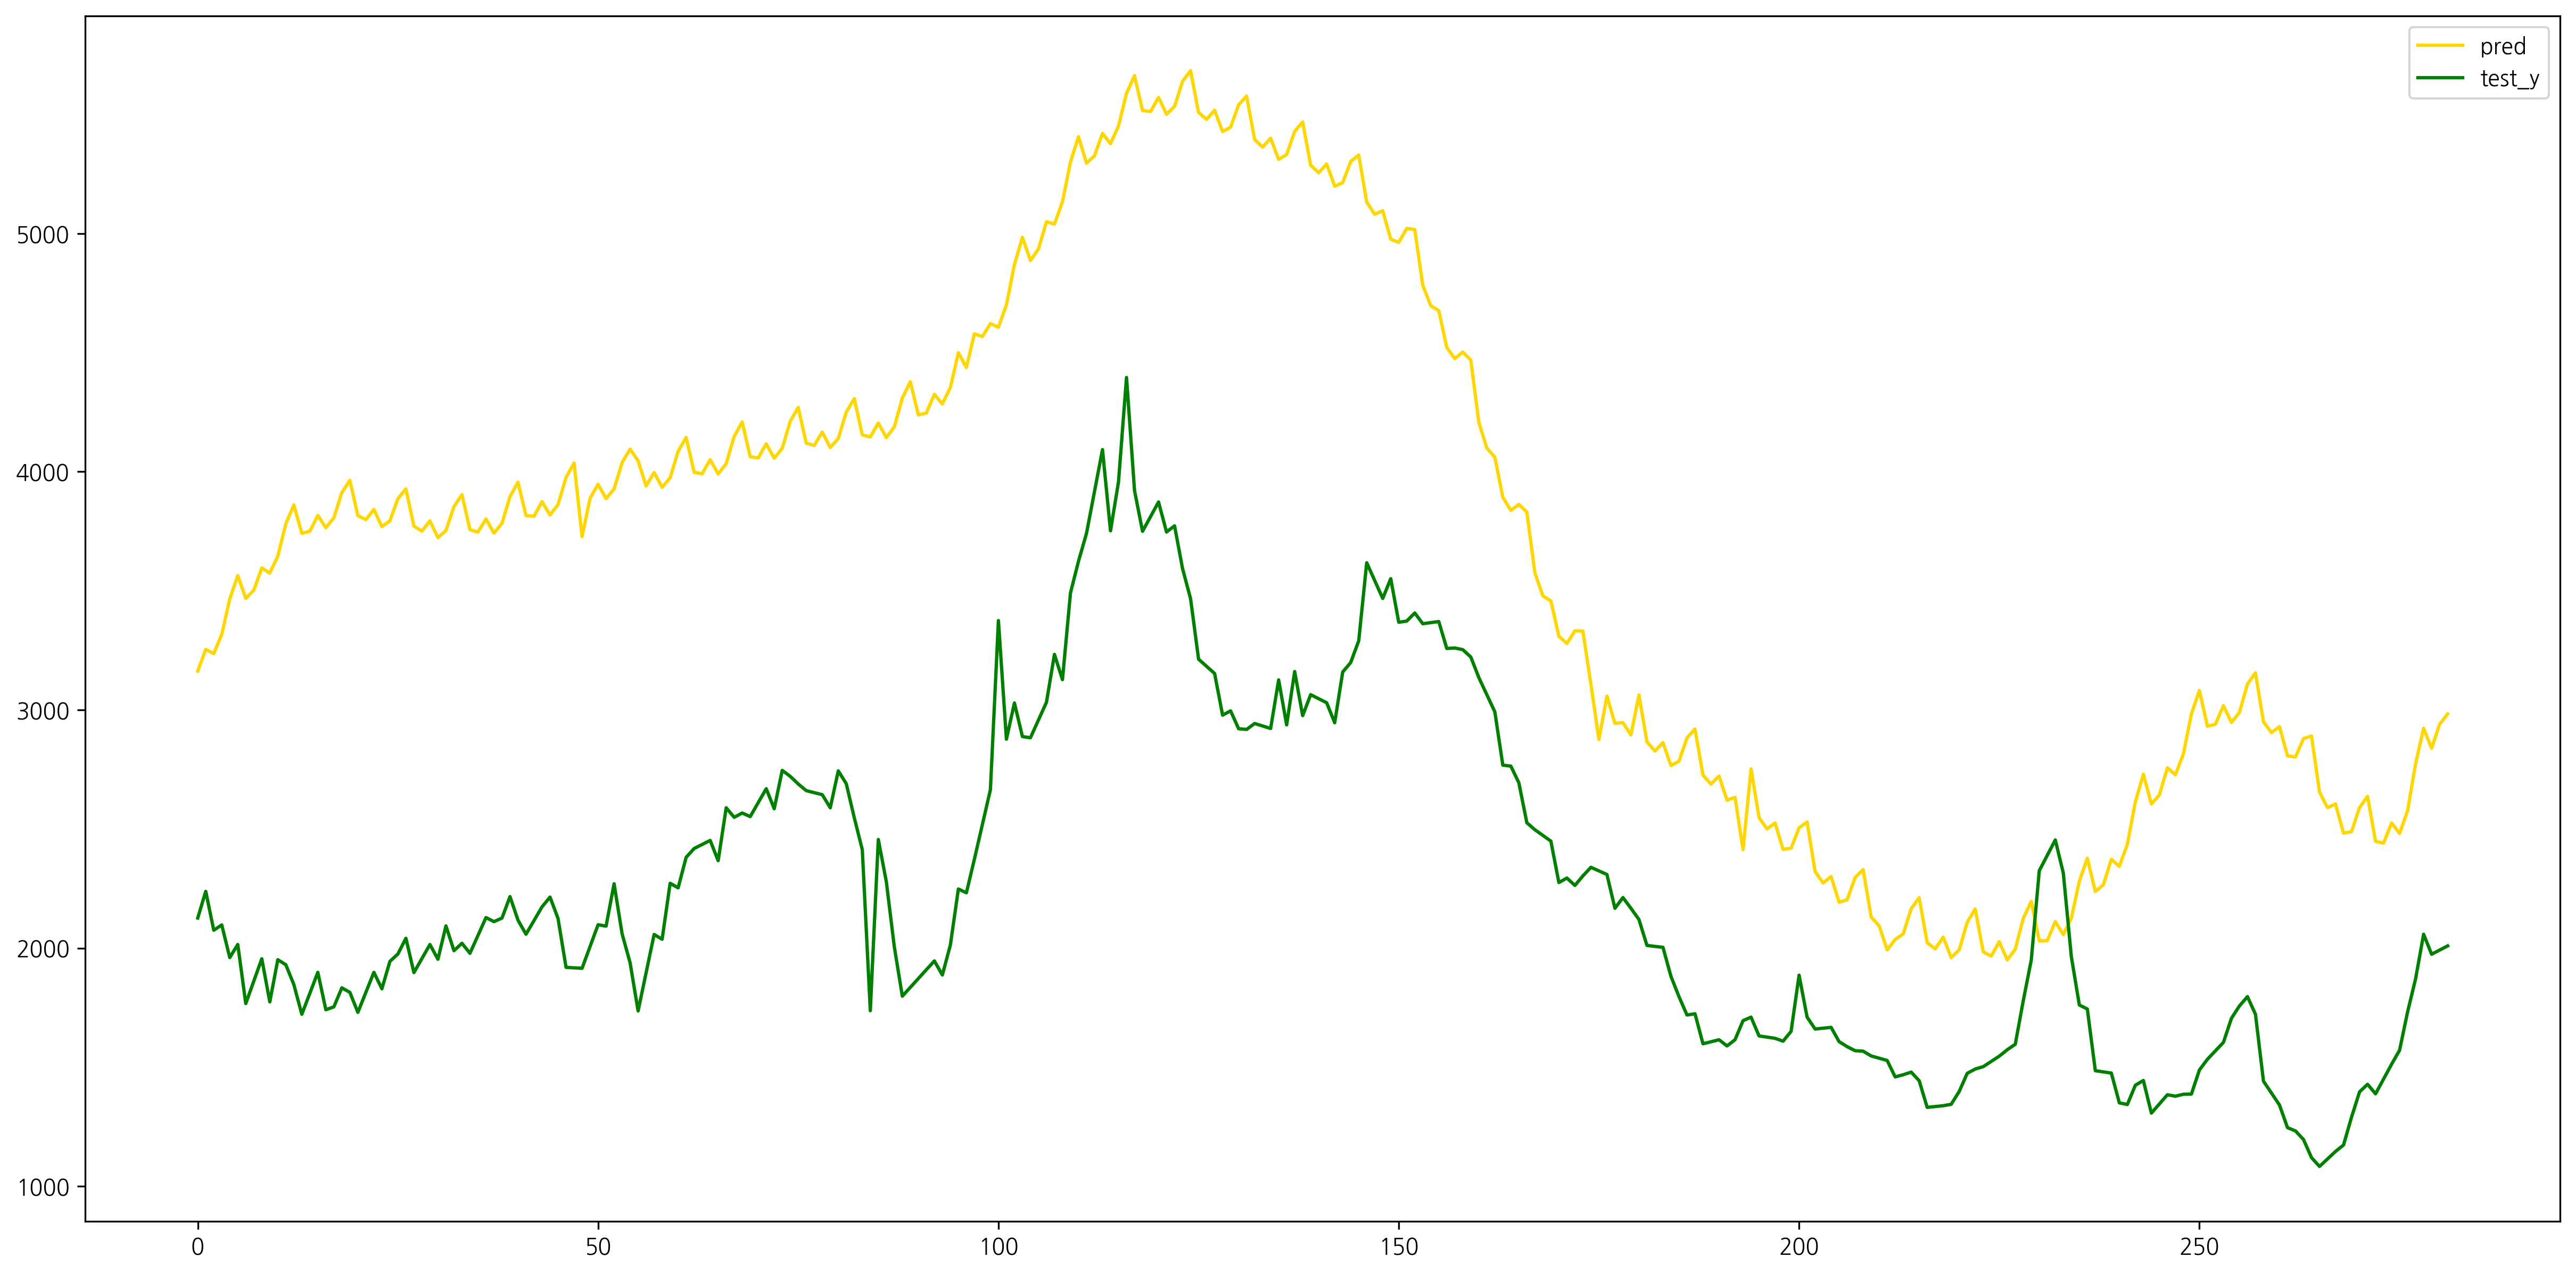

In [379]:
my_nong1.get_plot_prophet()

In [380]:
from sympy import Shi

weeks = [1],# 2, 4] #
features = ['팽이버섯', '캠벨얼리', '대파', '깻잎', '토마토']  

week1=[]
# week2=[]
# week4=[]

for week in weeks:
  print(week)
  for feature in features:
    my_nong1 = Nong1(df, private2)
    my_nong1.set_feature(feature)
    my_nong1.set_target(week)
    print(my_nong1.set_target(week))
    my_nong1.set_model_prophet()
    if week == 1:
      week1.append(my_nong1.get_price_prophet())
    # if week == 2:
    #   week2.append(my_nong1.get_price_prophet())
    # if week == 4:
    #   week4.append(my_nong1.get_price_prophet())
    print(feature)

[1]
None


KeyError: ignored

In [ ]:
# print(week1[0][1770])#  week2, week4
# print(week1[1][1770])
# print(week1[2][1770])
# print(week1[3][1770])
# print(week1[4][1770])
week1, # week2,  week4

In [ ]:
from pyrsistent import b
from datetime import datetime

date = '20201106'

feature = [ '대파_가격(원/kg)', '깻잎_가격(원/kg)','팽이버섯_가격(원/kg)', '토마토_가격(원/kg)', '캠벨얼리_가격(원/kg)']
# submission = submission.set_index('예측대상일자')
submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+1week', feature] = week1
# submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+2week', feature] = week2
# submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+4week', feature] = week4
submission.reset_index(drop=False, inplace=True)
title = 'submissionLGBM' + date + '.csv'

In [ ]:
submission.drop(columns=['배추_가격(원/kg)', '무_가격(원/kg)', '양파_가격(원/kg)', '건고추_가격(원/kg)',
       '마늘_가격(원/kg)',  '얼갈이배추_가격(원/kg)', '양배추_가격(원/kg)',
       '시금치_가격(원/kg)', '미나리_가격(원/kg)', '당근_가격(원/kg)', '파프리카_가격(원/kg)', '새송이_가격(원/kg)', 
       '청상추_가격(원/kg)', '백다다기_가격(원/kg)', '애호박_가격(원/kg)','샤인마스캇_가격(원/kg)'], inplace= True)

In [ ]:
submission2 = submission[228:].round(2)
submission2

In [ ]:
# 실제값과 비교! 
private2 = private2[['date','요일','대파_가격(원/kg)', '깻잎_가격(원/kg)','팽이버섯_가격(원/kg)', '토마토_가격(원/kg)', '캠벨얼리_가격(원/kg)']]
private2_week = private2[::7]
private2_week[1:5]

In [ ]:
submission2.to_csv(processed_path + title, encoding='utf-8-sig', index = False)

- ds = 날짜 데이터(시간데이터)
- yhat = 예측 값
- yhat_lower = 예측 데이터 최소값
- yhat_upper = 예측 데이터 최대값